##### Import the libraries

In [ ]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from torchvision.ops import nms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from ultralytics.utils.metrics import Metric
import pandas as pd
import matplotlib.pyplot as plt


##### split the dataset & create annotation bsed on yolo requirements

In [2]:
# Paths for input data
image_dir = os.path.join("ZJU_dataset_2", "images")
annotation_dir = os.path.join("ZJU_dataset_2", "annotation")

# Paths for YOLO-formatted dataset
output_dir = "datasets"
train_images_dir = os.path.join(output_dir, "train", "images")
train_labels_dir = os.path.join(output_dir, "train", "labels")
val_images_dir = os.path.join(output_dir, "val", "images")
val_labels_dir = os.path.join(output_dir, "val", "labels")

# Create output directories
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Function to convert annotations to YOLO format
def convert_to_yolo_format(annotation_path, image_width, image_height):
    with open(annotation_path) as f:
        data = json.load(f)

    yolo_annotations = []
    for shape in data["shapes"]:
        if shape["label"] == "window":  # Filter for "window" objects
            points = shape["points"]
            x_coords = [p[0] for p in points]
            y_coords = [p[1] for p in points]
            x_min = min(x_coords)
            y_min = min(y_coords)
            x_max = max(x_coords)
            y_max = max(y_coords)

            # Convert to YOLO format [class_id, center_x, center_y, width, height]
            center_x = ((x_min + x_max) / 2) / image_width
            center_y = ((y_min + y_max) / 2) / image_height
            width = (x_max - x_min) / image_width
            height = (y_max - y_min) / image_height

            yolo_annotations.append(f"0 {center_x} {center_y} {width} {height}")

    return yolo_annotations

# Load all image filenames and split into train/val sets
image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
train_files, val_files = train_test_split(image_filenames, test_size=0.2, random_state=42)

# Process and save train and val data
for dataset, image_files, images_dir, labels_dir in [
    ("train", train_files, train_images_dir, train_labels_dir),
    ("val", val_files, val_images_dir, val_labels_dir)
]:
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        annotation_path = os.path.join(annotation_dir, f"{os.path.splitext(img_file)[0]}.json")

        # Copy image to output directory
        shutil.copy(img_path, images_dir)

        # Open image to get dimensions
        with Image.open(img_path) as img:
            width, height = img.size

        # Convert annotations to YOLO format and save
        yolo_annotations = convert_to_yolo_format(annotation_path, width, height)
        label_path = os.path.join(labels_dir, f"{os.path.splitext(img_file)[0]}.txt")
        with open(label_path, "w") as label_file:
            label_file.write("\n".join(yolo_annotations))

print(f"Dataset organized successfully!")
print(f"Train images: {len(train_files)}, Validation images: {len(val_files)}")

Dataset organized successfully!
Train images: 200, Validation images: 50


##### checking the input data

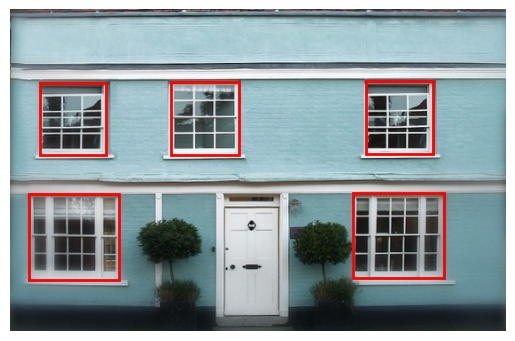

In [3]:
def visualize_annotations_by_index(dataset_path, index):
    # Construct paths for images and labels
    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    # Get sorted list of image and label files
    image_files = sorted(os.listdir(images_path))
    label_files = sorted(os.listdir(labels_path))

    # Ensure the index is valid
    if index < 0 or index >= len(image_files):
        raise ValueError(f"Invalid index: {index}. Must be between 0 and {len(image_files) - 1}.")

    # Get the image and label file for the given index
    image_file = os.path.join(images_path, image_files[index])
    label_file = os.path.join(labels_path, label_files[index])

    # Load the image
    img = Image.open(image_file)
    img_width, img_height = img.size

    # Load annotations
    with open(label_file, 'r') as f:
        lines = f.readlines()

    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for line in lines:
        parts = line.strip().split()
        cls, x_center, y_center, width, height = map(float, parts)

        # Convert normalized coordinates to pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculate box corners
        x_min = x_center - width / 2
        y_min = y_center - height / 2

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')

        # Add the rectangle to the plot
        ax.add_patch(rect)

    plt.axis('off')  # Hide axes for better visualization
    plt.show()

# Example usage
dataset_path = "datasets/train"
index = 3  # 0-based index
visualize_annotations_by_index(dataset_path, index)

##### Define The Model

In [4]:
# Load a pretrained YOLO model (e.g., YOLOv8n for a lightweight version)
model = YOLO('yolov8n.pt')  # Replace with yolov8s.pt, yolov8m.pt, etc., as needed

##### Hyper parameters tuning 

In [ ]:
import random
from ultralytics import YOLO

def find_best_hyperparameters(data_path, project_name, num_trials=10):
    """
    Function to find the best hyperparameters for YOLO model training.
    
    Parameters:
        data_path (str): Path to the data.yaml file.
        project_name (str): Name of the project folder for saving results.
        num_trials (int): Number of random trials for hyperparameter search.
        
    Returns:
        dict: Best hyperparameters and their corresponding validation results.
    """
    best_hyperparams = None
    best_score = float('-inf')

    # Define hyperparameter ranges
    hyperparameter_space = {
        "epochs": [5, 10, 20],
        "batch_size": [8, 16, 32],
        "learning_rate": [1e-4, 1e-3, 1e-2],
        "momentum": [0.8, 0.9, 0.95],
        "weight_decay": [1e-5, 1e-4, 1e-3]
    }

    for trial in range(num_trials):
        # Randomly sample hyperparameters
        epochs = random.choice(hyperparameter_space["epochs"])
        batch_size = random.choice(hyperparameter_space["batch_size"])
        learning_rate = random.choice(hyperparameter_space["learning_rate"])
        momentum = random.choice(hyperparameter_space["momentum"])
        weight_decay = random.choice(hyperparameter_space["weight_decay"])

        print(f"Trial {trial + 1}/{num_trials}: Testing with hyperparameters:")
        print(f"  Epochs: {epochs}, Batch Size: {batch_size}, Learning Rate: {learning_rate}")
        print(f"  Momentum: {momentum}, Weight Decay: {weight_decay}")

        # Create and train the model
        model = YOLO("yolov8n.pt")  # Replace with appropriate YOLO model
        model.train(
            data=data_path,
            epochs=epochs,
            batch=batch_size,
            lr0=learning_rate,
            momentum=momentum,
            weight_decay=weight_decay,
            project=project_name,
            name=f"trial_{trial + 1}"
        )

        # Validate the model
        results = model.val(data=data_path)
        mAP_50 = results.box.map50  # Mean Average Precision at IoU 0.5

        print(f"  Validation mAP@0.5: {mAP_50}")

        # Update best hyperparameters if the current trial is better
        if mAP_50 > best_score:
            best_score = mAP_50
            best_hyperparams = {
                "epochs": epochs,
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "momentum": momentum,
                "weight_decay": weight_decay,
                "map_50": mAP_50
            }

    print("Best Hyperparameters Found:")
    print(best_hyperparams)
    return best_hyperparams

In [ ]:
'''
data_path = "yolo_data.yaml"
project_name = "FacadeDetection"

best_hyperparams = find_best_hyperparameters(data_path, project_name, num_trials=10)

print("Optimal Hyperparameters:")
print(best_hyperparams)
'''

##### Train the model

In [5]:
# https://docs.ultralytics.com/modes/train/?utm_source=chatgpt.com#train-settings
# Train the model
model.train(
    data="yolo_data.yaml",         # Path to data.yaml or dict specifying train/val paths
    epochs=50,                # Number of epochs
    batch=2,            # Batch size
    project="FacadeDetection", # Project folder for saving results
    name="YOLOv8_training",    # Experiment name
    pretrained=True,           # Use pretrained weights
    patience = 3,
    optimizer = "SGD",
    cos_lr = True,
    momentum = 0.9,
    weight_decay = 0.0005,
    lr0 = 0.005,
    device = "cuda:0",
    imgsz = 256,
    plots = True,
    amp=False
)

New https://pypi.org/project/ultralytics/8.3.69 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.58  Python-3.10.0 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_data.yaml, epochs=50, time=None, patience=3, batch=2, imgsz=256, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=FacadeDetection, name=YOLOv8_training24, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning C:\Users\mohamad\WWR\datasets\train\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
val: Scanning C:\Users\mohamad\WWR\datasets\val\labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to FacadeDetection\YOLOv8_training24\labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to FacadeDetection\YOLOv8_training24
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.556G      2.047      3.294      1.249         50        256: 100%|██████████| 100/100 [00:11<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.50it/s]

                   all         50        659     0.0381      0.868      0.102     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.533G      1.582       2.34      1.098         73        256: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.16it/s]

                   all         50        659      0.651      0.654      0.675      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.533G      1.636      1.434      1.068         43        256: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.48it/s]

                   all         50        659       0.71      0.661      0.718      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.531G      1.605      1.314      1.053         16        256: 100%|██████████| 100/100 [00:08<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 15.17it/s]


                   all         50        659      0.777      0.717      0.788      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.533G      1.614      1.147      1.034         55        256: 100%|██████████| 100/100 [00:08<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 17.08it/s]


                   all         50        659      0.783       0.73      0.793      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.533G      1.534      1.094      1.036         58        256: 100%|██████████| 100/100 [00:09<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 15.49it/s]

                   all         50        659      0.794      0.779      0.831      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.533G      1.511      1.055      1.024         38        256: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 14.68it/s]

                   all         50        659      0.839      0.771      0.837      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.533G      1.484     0.9826      0.994         29        256: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.21it/s]

                   all         50        659      0.829      0.777      0.836      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.533G      1.429      1.018      1.011         11        256: 100%|██████████| 100/100 [00:08<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.80it/s]

                   all         50        659      0.845      0.788      0.852      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.533G      1.416     0.9511      1.004         47        256: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 17.01it/s]

                   all         50        659      0.835      0.798      0.854      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.531G       1.42      0.972     0.9991         43        256: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 15.75it/s]

                   all         50        659      0.821      0.816      0.862      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.533G      1.382     0.9251     0.9918         58        256: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.80it/s]

                   all         50        659      0.841      0.805       0.87      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.533G      1.403     0.9329     0.9641        107        256: 100%|██████████| 100/100 [00:08<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 15.26it/s]

                   all         50        659      0.844      0.822      0.869      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.531G      1.376     0.9075     0.9718         15        256: 100%|██████████| 100/100 [00:07<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 15.43it/s]

                   all         50        659      0.838       0.83       0.87      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.533G      1.304     0.9038     0.9693         40        256: 100%|██████████| 100/100 [00:08<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 17.37it/s]

                   all         50        659      0.865      0.798      0.866      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.531G      1.347     0.9284      0.996         24        256: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.41it/s]

                   all         50        659      0.836      0.815      0.863      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.533G      1.289     0.9037     0.9638         40        256: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.84it/s]

                   all         50        659      0.841       0.83      0.873      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.533G      1.261     0.8636     0.9536         23        256: 100%|██████████| 100/100 [00:08<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.85it/s]

                   all         50        659      0.846      0.847      0.881      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.533G      1.268     0.8737     0.9632         28        256: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.37it/s]

                   all         50        659      0.852      0.837      0.878      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.533G      1.285     0.8909     0.9669         18        256: 100%|██████████| 100/100 [00:08<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 16.34it/s]

                   all         50        659       0.87       0.83      0.882      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.531G       1.31     0.8645      0.954         34        256: 100%|██████████| 100/100 [00:08<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 15.77it/s]

                   all         50        659      0.851      0.825      0.866       0.54
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 18, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



21 epochs completed in 0.060 hours.
Optimizer stripped from FacadeDetection\YOLOv8_training24\weights\last.pt, 6.2MB
Optimizer stripped from FacadeDetection\YOLOv8_training24\weights\best.pt, 6.2MB

Validating FacadeDetection\YOLOv8_training24\weights\best.pt...
Ultralytics 8.3.58  Python-3.10.0 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:00<00:00, 13.95it/s]


                   all         50        659      0.848      0.847      0.881      0.547
Speed: 0.8ms preprocess, 7.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to FacadeDetection\YOLOv8_training24


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000012A222F2110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

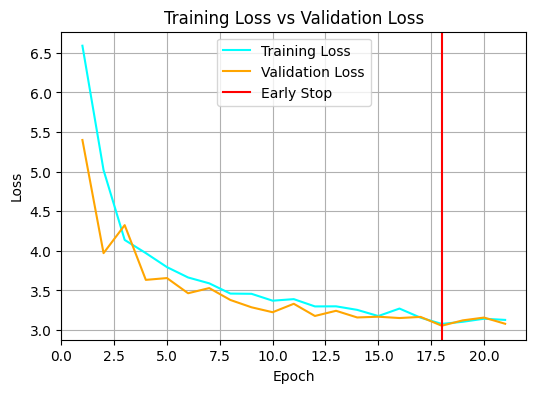

In [ ]:
# Load results.csv
df = pd.read_csv("FacadeDetection/YOLOv8_training24/results.csv", sep=",")

# Extract values
epochs = df["epoch"]
train_loss = df["train/box_loss"] + df["train/cls_loss"] + df["train/dfl_loss"]
val_loss = df["val/box_loss"] + df["val/cls_loss"] + df["val/dfl_loss"]

# Find Early Stopping Epoch (based on patience=3)
early_stop_epoch = epochs.iloc[-1] - 3  

# Plot Training and Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, label="Training Loss", color="cyan")
plt.plot(epochs, val_loss, label="Validation Loss", color="orange")

# Mark Early Stopping Epoch
plt.axvline(early_stop_epoch, color="red", linestyle="-", label="Early Stop")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


##### load the trained weights

In [6]:
# Load the custom-trained weights
model = YOLO('FacadeDetection/YOLOv8_training23/weights/best.pt')

##### validate the model

In [7]:
results = model.val(
    data="yolo_data.yaml",         # Path to data.yaml or dict specifying train/val paths
    epochs=50,                # Number of epochs
    batch=16,            # Batch size
    project="FacadeDetection", # Project folder for saving results
    name="YOLOv8_training_val",    # Experiment name
    plots = True,
    iou = 0.5,     # Sets the Intersection Over Union (IoU) threshold for Non-Maximum Suppression (NMS).
    device = "cuda:0"
)
# print(results)

Ultralytics 8.3.58  Python-3.10.0 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\mohamad\WWR\datasets\val\labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


                   all         50        659      0.863      0.844      0.884       0.54
Speed: 0.7ms preprocess, 24.6ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to FacadeDetection\YOLOv8_training_val7


In [8]:
print("Mean average precision:", results.box.map)
print("Mean average precision at IoU=0.50:", results.box.map50)
print("Precision:", results.box.p)
print("Recall:", results.box.r)
print("F1 score:", results.box.f1)

Mean average precision: 0.5395757855890359
Mean average precision at IoU=0.50: 0.8836310185279178
Precision: [    0.86308]
Recall: [     0.8437]
F1 score: [    0.85328]


##### visualizing the results (predicitons)


image 1/1 c:\Users\mohamad\WWR\Evaluation_subset\rectified_facade_DENW11AL0000h3Gt.jpg: 224x256 6 windows, 51.1ms
Speed: 1.0ms preprocess, 51.1ms inference, 4.1ms postprocess per image at shape (1, 3, 224, 256)


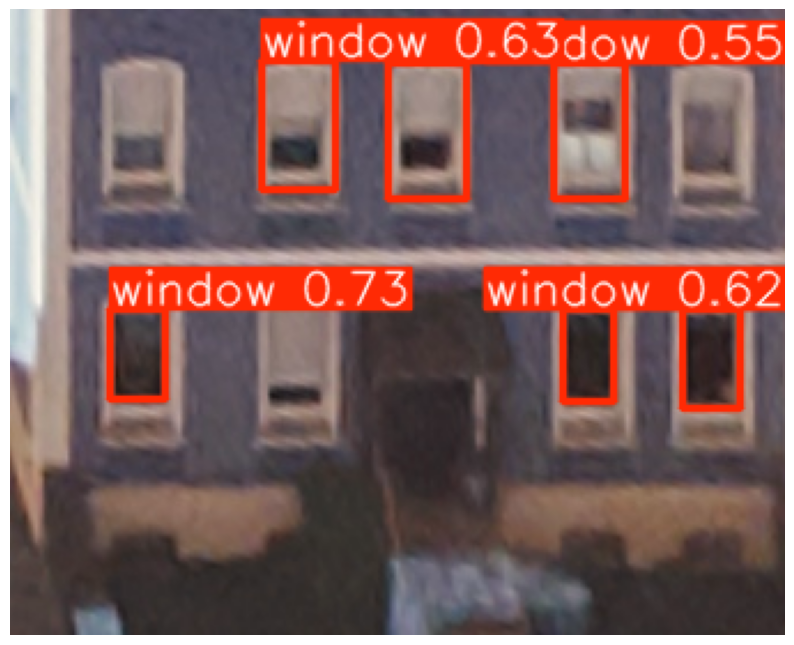

In [9]:
# Define the image path
image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Gt.jpg")
# image_path = os.path.join("datasets", "train", "images", "00001.jpg")
# image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Ho.jpg")

# Run prediction
results = model.predict(source=image_path, conf=0.5, save=False, save_txt=False, show=False)

# print("results", results)

# Load and visualize the image with predictions
annotated_image = results[0].plot()  # Plot the results on the image

# Display the image using Matplotlibs
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()